In [12]:
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine

sns.set_theme()
warnings.simplefilter(action='ignore', category=FutureWarning)

# Read and explore the data

In [13]:
df = pd.read_csv('../data/raw/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166915 entries, 0 to 1166914
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1166915 non-null  int64  
 1   vendor_id           1166915 non-null  int64  
 2   pickup_datetime     1166915 non-null  object 
 3   passenger_count     1166915 non-null  int64  
 4   pickup_longitude    1166915 non-null  float64
 5   pickup_latitude     1166915 non-null  float64
 6   dropoff_longitude   1166915 non-null  float64
 7   dropoff_latitude    1166915 non-null  float64
 8   store_and_fwd_flag  1166915 non-null  object 
 9   trip_duration       1166915 non-null  int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 89.0+ MB


In [14]:
df.describe().round()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1166915.0,1166915.0,1166915.0,1166915.0,1166915.0,1166915.0,1166915.0,1166915.0
mean,583457.0,2.0,2.0,-74.0,41.0,-74.0,41.0,959.0
std,336859.0,0.0,1.0,0.0,0.0,0.0,0.0,5625.0
min,0.0,1.0,0.0,-122.0,34.0,-122.0,32.0,1.0
25%,291728.0,1.0,1.0,-74.0,41.0,-74.0,41.0,397.0
50%,583457.0,2.0,1.0,-74.0,41.0,-74.0,41.0,662.0
75%,875186.0,2.0,2.0,-74.0,41.0,-74.0,41.0,1075.0
max,1166914.0,2.0,9.0,-61.0,52.0,-61.0,44.0,3526282.0


## 01 - Identify and Handle Anomalies

Analyze the daily trip count and identify two anomalous points in the data (e.g., unusually high or low demand).

In [15]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_date'] = df['pickup_datetime'].dt.date

daily_trips = df.groupby('pickup_date').size().reset_index(name='trip_count')

trips_mean = daily_trips['trip_count'].mean()
trips_std = daily_trips['trip_count'].std()

print("the trip count mean:", trips_mean)
print("the trip count standard deviation:", trips_std)

daily_trips.head()

the trip count mean: 6411.620879120879
the trip count standard deviation: 737.2980343015016


,pickup_date,trip_count
0,2016-01-01,5718
1,2016-01-02,5204
2,2016-01-03,5118
3,2016-01-04,5416
4,2016-01-05,5775


Calculate the lower and upper pound of the normal trip count days, I have choose the $1.6$ value as a threshold after trying multiple values. 

In [16]:
threshold = 1.6

lower_pound = trips_mean - threshold * trips_std
upper_pound = trips_mean + threshold * trips_std

print("lower pound of trip count: ", lower_pound)
print("upper pound of trip count: ", upper_pound)

lower pound of trip count:  5231.944024238476
upper pound of trip count:  7591.297734003282


In [17]:
high_anomalies = daily_trips[daily_trips['trip_count'] > upper_pound]
low_anomalies = daily_trips[daily_trips['trip_count'] < lower_pound]

anomalous_days = pd.concat([high_anomalies, low_anomalies])

df['is_anomaly'] = 0
df.loc[df['pickup_date'].isin(anomalous_days['pickup_date']), 'is_anomaly'] = 1

df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,is_anomaly
0,0,2,2016-06-29 18:21:02,1,-73.862762,40.768822,-73.891701,40.746689,N,1133,2016-06-29,0
1,1,2,2016-04-25 13:03:26,1,-73.958038,40.783237,-73.975510,40.760853,N,887,2016-04-25,0
2,2,2,2016-05-07 12:36:09,1,-73.969460,40.785519,-73.989243,40.771748,N,686,2016-05-07,0
3,3,1,2016-05-14 18:44:17,1,-73.981743,40.736549,-73.998352,40.726440,N,818,2016-05-14,0
4,4,2,2016-04-10 22:51:25,1,-73.977913,40.752609,-73.975647,40.733139,N,951,2016-04-10,0


Now, visualizing the trip count with the lower and upper bound.

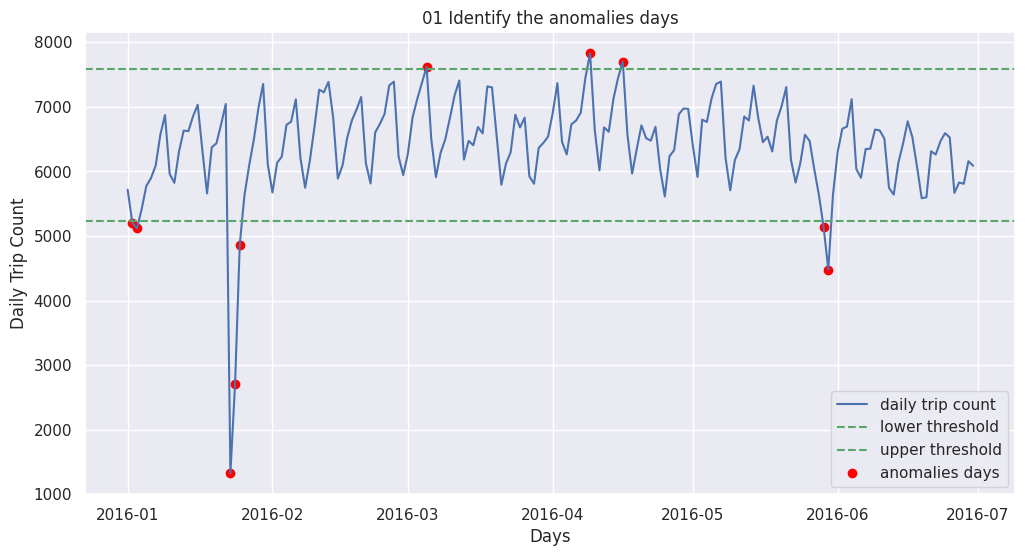

In [18]:
plt.figure(figsize=(12,6))
plt.plot(daily_trips['pickup_date'], daily_trips['trip_count'], label='daily trip count')
plt.axhline(y=lower_pound, color='g', linestyle='--', label='lower threshold')
plt.axhline(y=upper_pound, color='g', linestyle='--', label='upper threshold')
plt.scatter(anomalous_days['pickup_date'], anomalous_days['trip_count'], color='red', label='anomalies days')
plt.title('01 Identify the anomalies days')
plt.xlabel('Days')
plt.ylabel('Daily Trip Count')
plt.legend()
plt.show()

## 02 - Extract useful temporal features from the pickup_datetime column

- pickup_day_of_year (ordinal day of the year)
- pickup_day_of_week (0=Monday, 6=Sunday)
- pickup_hour_of_day (hour of the day).

In [19]:
df['pickup_day_of_year'] = df['pickup_datetime'].dt.dayofyear
df['pickup_day_of_week'] = df['pickup_datetime'].dt.weekday 
df['pickup_hour_of_day'] = df['pickup_datetime'].dt.hour

df[['pickup_day_of_year', 'pickup_day_of_week', 'pickup_hour_of_day']].head()

,pickup_day_of_year,pickup_day_of_week,pickup_hour_of_day
0,181,2,18
1,116,0,13
2,128,5,12
3,135,5,18
4,101,6,22


## 03 - Analyze Traffic Congestion 

Calculate the average speed (distance divided by trip duration) for trips based on the day of the week and hour of the day. Using this analysis to create a categorical feature for traffic congestion levels.

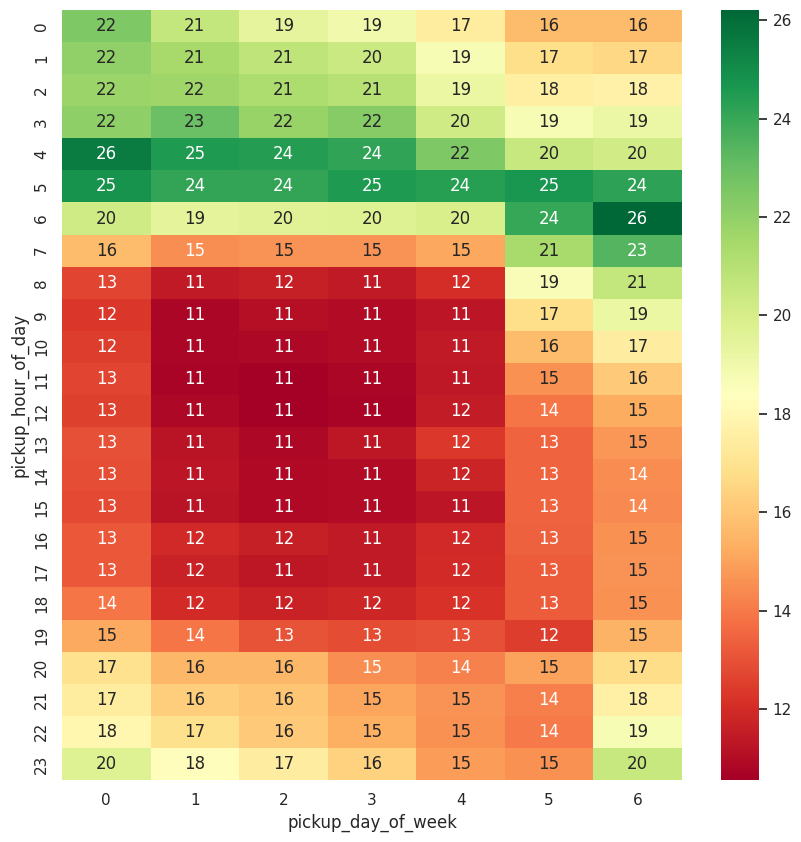

In [20]:
def vec_haversine(row):
    """function that calculates the distance from the latitude and longitude."""
    return haversine((row['pickup_latitude'], row['pickup_longitude']),(row['dropoff_latitude'], row['dropoff_longitude']))

df['trip_distance'] = df.apply(vec_haversine, axis=1)
df['speed'] = df['trip_distance'] / (df['trip_duration'] / 3600) # speed to be km/h

df_avg = df.groupby(['pickup_day_of_week', 'pickup_hour_of_day'])['speed'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10,10))
df_temp = df_avg.pivot(index='pickup_hour_of_day', columns='pickup_day_of_week', values='speed')
sns.heatmap(df_temp, annot=True, ax=ax, cmap='RdYlGn')
plt.show()

Visualizing the high traffic, (expected as the average speed in these times are very low)

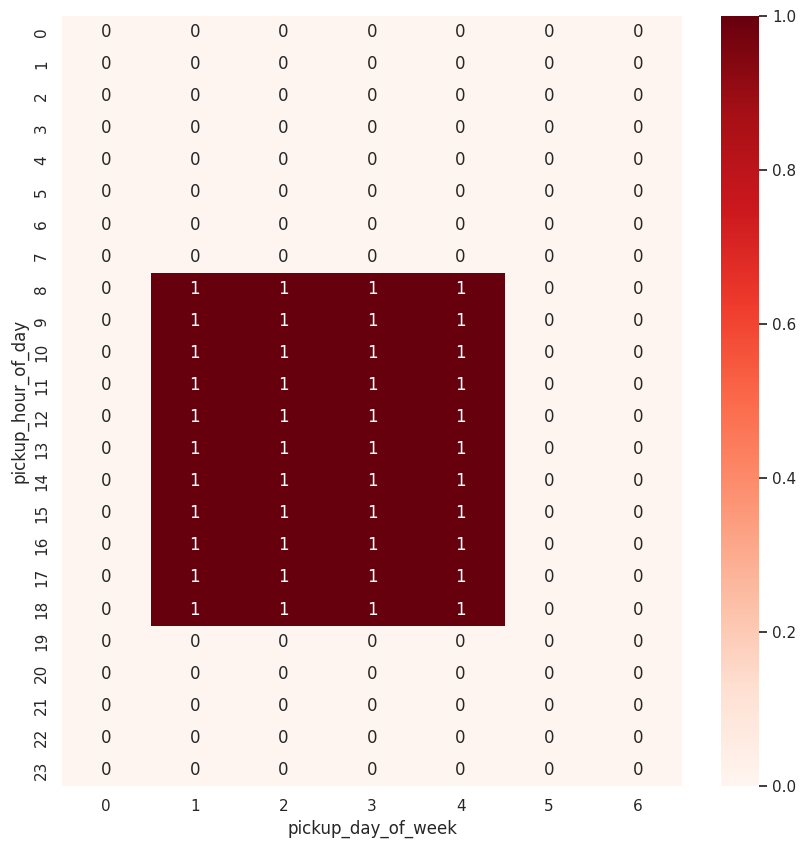

In [21]:
df_avg['traffic_congestion'] = 0
df_avg.loc[(((1 <= df_avg['pickup_day_of_week']) & (df_avg['pickup_day_of_week'] <= 4)) & \
            ((8 <= df_avg['pickup_hour_of_day']) & (df_avg['pickup_hour_of_day'] <= 18))), 'traffic_congestion'] = 1
df_grb = df_avg.groupby(['pickup_day_of_week', 'pickup_hour_of_day'])['traffic_congestion'].max().reset_index()
df_temp = df_avg.pivot(index='pickup_hour_of_day', columns='pickup_day_of_week', values='traffic_congestion')

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_temp, annot=True, ax=ax, cmap='Reds')
plt.show()

In [22]:
df['traffic_congestion'] = 0
df.loc[(((8 <= df['pickup_hour_of_day']) & (df['pickup_hour_of_day'] <= 18)) & \
            ((1 <= df['pickup_day_of_week']) & (df['pickup_day_of_week'] <= 4))), 'traffic_congestion'] = 1

df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,is_anomaly,pickup_day_of_year,pickup_day_of_week,pickup_hour_of_day,trip_distance,speed,traffic_congestion
0,0,2,2016-06-29 18:21:02,1,-73.862762,40.768822,-73.891701,40.746689,N,1133,2016-06-29,0,181,2,18,3.463783,11.005842,1
1,1,2,2016-04-25 13:03:26,1,-73.958038,40.783237,-73.975510,40.760853,N,887,2016-04-25,0,116,0,13,2.891369,11.734980,0
2,2,2,2016-05-07 12:36:09,1,-73.969460,40.785519,-73.989243,40.771748,N,686,2016-05-07,0,128,5,12,2.262639,11.873909,0
3,3,1,2016-05-14 18:44:17,1,-73.981743,40.736549,-73.998352,40.726440,N,818,2016-05-14,0,135,5,18,1.795032,7.899896,0
4,4,2,2016-04-10 22:51:25,1,-73.977913,40.752609,-73.975647,40.733139,N,951,2016-04-10,0,101,6,22,2.173392,8.227351,0


## 04 - Passenger Count Analysis

Explore the passenger_count column to identify:
- Common values (e.g., 1 or 2 passengers).
- Outliers (e.g., trips with zero or unusually high passenger counts).

In [23]:
passenger_count = df['passenger_count'].value_counts().sort_index()
print(passenger_count)

passenger_count
0        47
1    826979
2    168433
3     47778
4     22646
5     62383
6     38645
7         2
8         1
9         1
Name: count, dtype: int64


In [24]:
outliers = [0, 7, 8, 9]
df = df[~df['passenger_count'].isin(outliers)]

df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,is_anomaly,pickup_day_of_year,pickup_day_of_week,pickup_hour_of_day,trip_distance,speed,traffic_congestion
0,0,2,2016-06-29 18:21:02,1,-73.862762,40.768822,-73.891701,40.746689,N,1133,2016-06-29,0,181,2,18,3.463783,11.005842,1
1,1,2,2016-04-25 13:03:26,1,-73.958038,40.783237,-73.975510,40.760853,N,887,2016-04-25,0,116,0,13,2.891369,11.734980,0
2,2,2,2016-05-07 12:36:09,1,-73.969460,40.785519,-73.989243,40.771748,N,686,2016-05-07,0,128,5,12,2.262639,11.873909,0
3,3,1,2016-05-14 18:44:17,1,-73.981743,40.736549,-73.998352,40.726440,N,818,2016-05-14,0,135,5,18,1.795032,7.899896,0
4,4,2,2016-04-10 22:51:25,1,-73.977913,40.752609,-73.975647,40.733139,N,951,2016-04-10,0,101,6,22,2.173392,8.227351,0
